# Solve surface volatiles according to outgassing+chemistry

In [4]:
import sys
sys.path.append("..")
from proteus.utils.surface_gases import *

import itertools
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [5]:
# https://stackoverflow.com/a/65972406
def _ecdf(a):
    a = np.sort(a)
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

### Set up initial options dict

In [6]:
OPTIONS = {}

OPTIONS['Phi_global'] = 1.0
OPTIONS['T_magma'] = 2500.0
OPTIONS['radius'] = 6.371e6 #* 1.875
OPTIONS['mass']   = 5.972e24 #* 7.99
OPTIONS['gravity'] = 6.67e-11 * OPTIONS['mass'] / (OPTIONS['radius']**2)
OPTIONS['hydrogen_earth_oceans'] = 8.0
OPTIONS['CH_ratio'] = 1.0
OPTIONS['fO2_shift_IW'] = 0.0
OPTIONS['nitrogen_ppmw'] = 4.0
OPTIONS['sulfur_ppmw'] = 300.0
OPTIONS['planet_coresize'] = 0.5

solvevol_vols = ['H2O', 'CO2', 'N2', 'H2', 'CO', 'CH4', 'S2', 'SO2']
for v in solvevol_vols:
    OPTIONS[v+"_included"] = 0
    OPTIONS[v+"_initial_bar"] = 0.0

OPTIONS["H2O_included"] = 1
OPTIONS["CO2_included"] = 1
OPTIONS["N2_included"]  = 1
OPTIONS["S2_included"]  = 1

OPTIONS["H2_included"]  = 1
OPTIONS["CO_included"]  = 1
OPTIONS["CH4_included"] = 1
OPTIONS["SO2_included"] = 1

print("Gravity = %.3f m.s-2" % OPTIONS["gravity"])

Gravity = 9.814 m.s-2


### Calculate total amount of each element in the system

In [7]:
OPTIONS["M_mantle"] = CalculateMantleMass(OPTIONS["radius"], OPTIONS["mass"], OPTIONS["planet_coresize"])
BACKUP_options = deepcopy(OPTIONS)

In [8]:
solvevol_target = get_target_from_params(OPTIONS)
# solvevol_target = get_target_from_pressures(OPTIONS)

print("Targets:")
print(solvevol_target)

Targets:
{'H': 1.24e+21, 'C': 1.24e+21, 'N': 1.8054299266814261e+19, 'S': 1.3540724450110695e+21}


### Parameter grid

In [9]:
indep_vars = {
    "fO2_shift_IW":             [-4, -2, 0, 2, 4],
    "CH_ratio":                 [0.1, 1.0, 2.0],
    "hydrogen_earth_oceans":    [1, 3, 10],
}

In [10]:
# convert to floats
for k in indep_vars.keys():
    indep_vars[k] = np.array(indep_vars[k], dtype=float)

# flatten the parameter grid
keys, values = zip(*indep_vars.items())
all_pts = [dict(zip(keys, v)) for v in itertools.product(*values)]
npts = len(all_pts)
print("Total points = %d"%npts)

# loop over points
for i in range(npts):
    print("    i = %03d / %03d = %4.1f%%"%(i+1,npts,100*(i+1)/npts))
    # get base params
    OPTIONS = deepcopy(BACKUP_options)

    # set params at this point
    p = all_pts[i]
    for k in p.keys():
        OPTIONS[k] = p[k]

    # solve
    solvevol_target = get_target_from_params(OPTIONS)
    p_d = equilibrium_atmosphere(solvevol_target, OPTIONS)

    # store
    for k in p_d.keys():
        all_pts[i][k] = p_d[k]


Total points = 45
    i = 001 / 045 =  2.2%
    i = 002 / 045 =  4.4%
    i = 003 / 045 =  6.7%
    i = 004 / 045 =  8.9%
    i = 005 / 045 = 11.1%
    i = 006 / 045 = 13.3%
    i = 007 / 045 = 15.6%
    i = 008 / 045 = 17.8%


/dataserver/users/formingworlds/nicholls/PROTEUS/src/proteus/utils/surface_gases.py:253: RuntimeWarning: invalid value encountered in log10
  ppmw = 10 ** (-0.738 + 0.876 * np.log10(p) - 5.44e-5 * p_total)
/dataserver/users/formingworlds/nicholls/PROTEUS/src/proteus/utils/surface_gases.py:309: RuntimeWarning: invalid value encountered in scalar power
  p_d['SO2']  = (gamma*pin['S2']*p_d['O2']**2)**0.5
/dataserver/users/formingworlds/nicholls/PROTEUS/src/proteus/utils/surface_gases.py:121: RuntimeWarning: invalid value encountered in scalar power
  return const*p**exponent
/dataserver/users/formingworlds/nicholls/PROTEUS/src/proteus/utils/surface_gases.py:226: RuntimeWarning: invalid value encountered in scalar power
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_shift)
/dataserver/users/formingworlds/nicholls/PROTEUS/src/proteus/utils/surface_gases.py:226: RuntimeWarning: overflow encountered in exp
  ppmw  = pb_N2**0.5 * np.exp(5908.0 * pb_tot**0.5/temp - 1.6*fO2_sh

    i = 009 / 045 = 20.0%
    i = 010 / 045 = 22.2%
    i = 011 / 045 = 24.4%
    i = 012 / 045 = 26.7%
    i = 013 / 045 = 28.9%
    i = 014 / 045 = 31.1%
    i = 015 / 045 = 33.3%
    i = 016 / 045 = 35.6%
    i = 017 / 045 = 37.8%
    i = 018 / 045 = 40.0%
    i = 019 / 045 = 42.2%
    i = 020 / 045 = 44.4%
    i = 021 / 045 = 46.7%
    i = 022 / 045 = 48.9%
    i = 023 / 045 = 51.1%
    i = 024 / 045 = 53.3%
    i = 025 / 045 = 55.6%
    i = 026 / 045 = 57.8%
    i = 027 / 045 = 60.0%
    i = 028 / 045 = 62.2%
    i = 029 / 045 = 64.4%
    i = 030 / 045 = 66.7%
    i = 031 / 045 = 68.9%
    i = 032 / 045 = 71.1%
    i = 033 / 045 = 73.3%
    i = 034 / 045 = 75.6%
    i = 035 / 045 = 77.8%
    i = 036 / 045 = 80.0%
    i = 037 / 045 = 82.2%
    i = 038 / 045 = 84.4%
    i = 039 / 045 = 86.7%
    i = 040 / 045 = 88.9%
    i = 041 / 045 = 91.1%
    i = 042 / 045 = 93.3%
    i = 043 / 045 = 95.6%
    i = 044 / 045 = 97.8%
    i = 045 / 045 = 100.0%


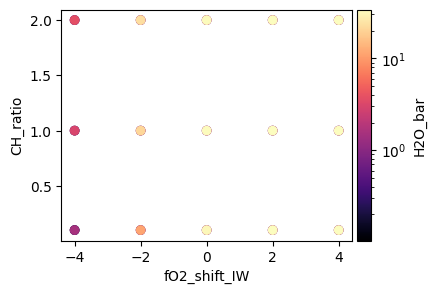

In [11]:
# plot scatter
plt.close("all")

x_key = "fO2_shift_IW"
y_key = "CH_ratio"
z_key = "H2O_bar"

x_arr, y_arr, z_arr = [], [], []
for i in range(npts):
    x_arr.append(all_pts[i][x_key])
    y_arr.append(all_pts[i][y_key])
    z_arr.append(all_pts[i][z_key])

fig,ax = plt.subplots(1,1, figsize=(4,3))

divider = make_axes_locatable(ax)
cmap = mpl.cm.magma
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = mpl.colors.LogNorm(vmin=np.amin(z_arr), vmax=np.amax(z_arr))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(z_key)

ax.scatter(x_arr, y_arr, c=z_arr, cmap=cmap, norm=norm)

ax.set(xlabel=x_key, ylabel=y_key)

plt.show()


### Plot ECDFs

In [49]:
dep_keys = ["H2O_vmr", "CO2_vmr", "H2_vmr", "P_surf"]

In [68]:
# invert parameter grid based on all keys...

result = {}
for k in indep_vars.keys():
    result[k] = []
for k in dep_keys:
    result[k] = []

for i in range(npts):
    for k in indep_vars.keys():
        result[k].append(all_pts[i][k])
    for k in dep_keys:
        val = all_pts[i][k]
        if "vmr" in k:
            val *= 100
        result[k].append(val)

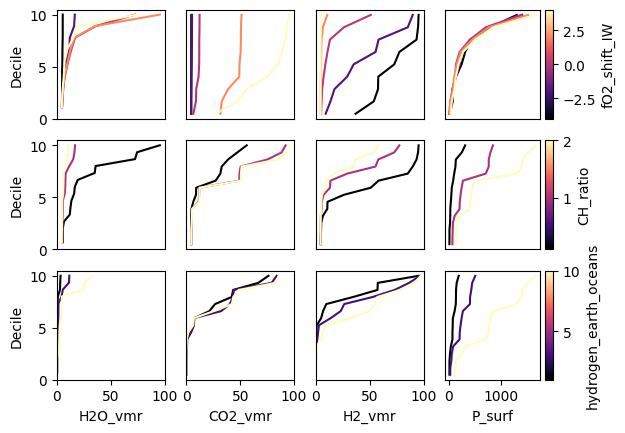

In [77]:
# create figure
cmap = mpl.cm.magma
ndep = len(dep_keys)
nind = len(indep_vars)
fig,axs = plt.subplots(nind, ndep)

# for each independent variable...
for i,k in enumerate(indep_vars.keys()):

    # create cbar
    divider = make_axes_locatable(axs[i,-1])
    cax = divider.append_axes('right', size="8%", pad=0.05)
    norm = mpl.colors.Normalize(vmin=np.amin(indep_vars[k]), vmax=np.amax(indep_vars[k]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label(k)

    # for each value of that variable...
    for j,v in enumerate(indep_vars[k]):

        # for all dep variables at this slice of indep vars
        for idx_dep, kk in enumerate(dep_keys):
            subset_y = []
            for ir,r in enumerate(result[k]):
                if np.isclose(r, v):
                    subset_y.append(result[kk][ir])
            dist_x, dist_y = _ecdf(subset_y)
            axs[i,idx_dep].plot(dist_x, dist_y*10, c=sm.to_rgba(v))


# decorate
for i in range(ndep):
    for j in range(nind):
        axs[j,i].set_yticks([])
        axs[j,0].set_yticks([0, 5, 10])
        axs[j,0].set_ylabel("Decile")

        if j < nind-1:
            axs[j,i].set_xticks([])

    axs[-1,i].set_xlabel(dep_keys[i])
    if "vmr" in dep_keys[i]:
        axs[-1,i].set_xlim(left=0, right=100)


plt.show()